# Introduction

- Infectious bursal disease (IBD) is an acute, highly contagious and immunosuppressive disease in chickens (Müller et al., 2003). IBD is caused by infectious bursal disease virus (IBDV), which is an RNA virus that belongs to the genus Avibirnavirus of the family Birnaviridae.
- Crohn's Disease and Ulcerative Colitis are two diseases that represent the primary variants of IBD, and they are distinct in their characteristics, though they share some common symptoms.

Source : *https://www.sciencedirect.com/science/article/abs/pii/S0378113519310533*

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, label_binarize
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')

In [2]:
patients = pd.read_csv('Patients_Data.csv')
patients = patients.rename(columns={"Crohn's": "Crohn"})

insurance = pd.read_csv('Insurance_Claims_Data.csv')

cpt_2019 = pd.read_csv('Translation tables/CPT_CCS_2019.csv')
cpt_2019.columns = cpt_2019.columns.str.replace(' ', '_')

icd = pd.read_csv('Translation tables/icd9dx2014.csv')
icd.columns = icd.columns.str.replace(' ', '_')

cpt4 = pd.read_csv('Translation tables/CPT4Codes2017.csv')
cpt4.columns = cpt4.columns.str.replace(' ', '_')

z_codes = pd.read_csv('Translation tables/Z_Codes.csv', encoding='latin-1')
z_codes.columns = z_codes.columns.str.replace(' ', '_')

In [31]:
icd.head(100)

,ICD9,Long_Diagnosis
0,x0010,Cholera due to vibrio cholerae
1,x0011,Cholera due to vibrio cholerae el tor
2,x0019,"Cholera, unspecified"
3,x0020,Typhoid fever
4,x0021,Paratyphoid fever A
...,...,...
95,x01081,"Other primary progressive tuberculosis, bacter..."
96,x01082,"Other primary progressive tuberculosis, bacter..."
97,x01083,"Other primary progressive tuberculosis, tuberc..."
98,x01084,"Other primary progressive tuberculosis, tuberc..."


In [18]:
icd['ICD9'] = icd['ICD9'].str.strip()

In [34]:
icd[icd['ICD9'].isin(['xV7231'])]

,ICD9,Long_Diagnosis
14348,xV7231,Routine gynecological examination


### Insurance claims DB

- **ID** : Unique identifier for each insurance claim.
- **Procedure_Date** : The date when the procedure or service was performed.
- **ClaimLineID** : Unique identifier for each line item in a claim.
- **Age** : Age of the patient.
- **Gender** : Gender of the patient.
- **DiagnosisCode1-5** : ICD-9 codes for diagnoses related to the claim; primary and secondary diagnoses.
- **ProcedureCode** : CPT4 or Hospital Revenue code for the procedure or service performed.
- **ProcedureCodeMod** : Modifier for the CPT4 code, providing additional information about the procedure.
- **DrugClass** : Classification of any prescribed drugs.
- **DrugName** : Name of the prescribed drug.
- **DrugStrength** : Dosage strength of the prescribed drug.
- **DrugQuantity** : Quantity of the drug dispensed.
- **DrugDaysSupply** : Number of days for which the drug is supplied.
- **EpisodeDescription** : Description of the health episode leading to the claim.
- **EpisodeDriver** : Primary factor driving the healthcare episode.
- **EpisodeCategory** : Category of the episode (e.g., outpatient, inpatient).
- **TotalChargeAmount** : Total amount charged for the claim.
### Granularity of rows
- 1 row -> 1 claim
- 1 clinic visit/complex procedure -> 1 to n claims (n rows)
- 1 line :
    * person's data
    * diagnostic (ICD9)
    * actual procedure (CPT4)
    * drug or other expense (“Z0” + Hospital_revenue_code)
    * expense amount
    * description and category
  
### Patient DB
- **ID** : Unique identifier for each patient.
- **Gender** : Gender of the patient.
- **Age** : Age of the patient.
- **Crohn's** : Indicator of whether the patient has Crohn (1, Hidden or NaN).
- **UC** : Indicator of whether the patient has UC Ulcerative Colitis (1, Hidden or NaN).

# First analysis

In [3]:
# 100 patients
print('Number of patients :', len(set(insurance.ID)))
print(set(insurance.ID) == set(patients.ID))

Number of patients : 100
True


**There are 100 patients in this study**

In [4]:
# Class check
print(patients.Crohn.value_counts(normalize=True))
print()
print(patients.UC.value_counts(normalize=True))

Hidden    0.6
1         0.4
Name: Crohn, dtype: float64

Hidden    0.7
1         0.3
Name: UC, dtype: float64


**The classes don't look imbalanced at first sight**

In [5]:
merged_data = pd.merge(patients[['ID', 'Crohn', 'UC']], insurance, on='ID', how='inner')

In [6]:
# Class check after merge
print(merged_data.Crohn.value_counts(normalize=True))
print()
print(merged_data.UC.value_counts(normalize=True))

Hidden    0.534113
1         0.465887
Name: Crohn, dtype: float64

Hidden    0.675273
1         0.324727
Name: UC, dtype: float64


In [7]:
#merged_data['UC'] = merged_data['UC'].fillna(0)
#merged_data['Crohn'] = merged_data['Crohn'].fillna(0)

In [8]:
print(len(set(merged_data['ID'][(merged_data['UC'] == '1') & (merged_data['Crohn'] == '1')])))
print(len(set(merged_data['ID'][(merged_data['UC'] == '1') & (merged_data['Crohn'].isna())])))
print(len(set(merged_data['ID'][(merged_data['UC'].isna()) & (merged_data['Crohn'] == '1')])))
print(len(set(merged_data['ID'][(merged_data['UC'].isna()) & (merged_data['Crohn'].isna())])))
print(len(set(merged_data['ID'][(merged_data['UC'] =='Hidden') & (merged_data['Crohn'] == 'Hidden')])))

6
12
22
18
42


**Now we can see the classes are a little bit imbalanced in fact.**
- Patients with UC and Crohn : 6%
- Patients with UC : 12%
- Patients with Crohn : 22%
- Patients with no pathology : 18%
- Patients with Hidden result : 42%

* Patients with Hidden results will be my test set and we will try to predict the pathology of these patients although the test set (42%) looks big and the train set (58%) is small.

# Missing values and data cleaning

In [9]:
merged_data.dtypes

ID                     int64
Crohn                 object
UC                    object
Procedure_Date        object
ClaimLineID            int64
Age                    int64
Gender                object
DiagnosisCode1        object
DiagnosisCode2        object
DiagnosisCode3        object
DiagnosisCode4        object
DiagnosisCode5        object
ProcedureCode         object
ProcedureCodeMod      object
DrugClass             object
DrugName              object
DrugStrength          object
DrugQuantity           int64
DrugDaysSupply         int64
EpisodeDescription    object
EpisodeDriver         object
EpisodeCategory       object
TotalChargeAmount     object
dtype: object

In [10]:
merged_data['DiagnosisCode1'] = merged_data['DiagnosisCode1'].fillna('0')
merged_data['DiagnosisCode2'] = merged_data['DiagnosisCode2'].fillna('0')
merged_data['DiagnosisCode3'] = merged_data['DiagnosisCode3'].fillna('0')
merged_data['DiagnosisCode4'] = merged_data['DiagnosisCode4'].fillna('0')
merged_data['DiagnosisCode5'] = merged_data['DiagnosisCode5'].fillna('0')

merged_data['Gender'] = merged_data['Gender'].replace({1: '1', 0: '0'})
merged_data['EpisodeDriver'] = merged_data['EpisodeDriver'].replace(
    {'                                                  ': 
     'Unassigned'})
merged_data['EpisodeDriver'] = merged_data['EpisodeDriver'].str.strip()

merged_data['EpisodeDescription'] = merged_data['EpisodeDescription'].str.strip()
merged_data['EpisodeDescription'] = merged_data['EpisodeDescription'].fillna('Unassigned')

In [11]:
# When EpisodeDescription is Unassigned : EpisodeDriver and EpisodeCategory are NaN
merged_data['EpisodeDriver'] = merged_data['EpisodeDriver'].fillna(merged_data['EpisodeDescription'])
merged_data['EpisodeCategory'] = merged_data['EpisodeCategory'].fillna(merged_data['EpisodeDescription'])

In [12]:
# When the Procedure doesn't involve any drugs 	DrugClass 	DrugName 	DrugStrength are NaN
merged_data['DrugClass'] = merged_data['DrugClass'].fillna('No_drug')
merged_data['DrugName'] = merged_data['DrugName'].fillna('No_drug')
merged_data['DrugStrength'] = merged_data['DrugStrength'].fillna('0')
cpt4[cpt4['CPT4'].isin(['73564', '99213', '20610', '90460', '45990', '99205'])]

,CPT4,Procedure
491,20610,"Drain/inject, joint/bursa"
5559,73564,"X-ray exam, knee, 4 or more"
8090,99205,"Office/outpatient visit, new"
8093,99213,"Office/outpatient visit, est"


In [13]:
procedure_code_mapping = merged_data.dropna(subset=['ProcedureCode', 'ProcedureCodeMod'])
procedure_code_mapping = procedure_code_mapping.groupby('ProcedureCode')['ProcedureCodeMod'].first().to_dict()

merged_data['ProcedureCodeMod'] = merged_data.apply(
    lambda row: procedure_code_mapping.get(row['ProcedureCode'], row['ProcedureCodeMod']) 
    if pd.isna(row['ProcedureCodeMod']) else row['ProcedureCodeMod'], 
    axis=1
)
merged_data['ProcedureCodeMod'] = merged_data['ProcedureCodeMod'].fillna('UNMENTIONNED')
merged_data['TotalChargeAmount'] = merged_data['TotalChargeAmount'].str.strip()
merged_data['TotalChargeAmount'] = merged_data['TotalChargeAmount'].replace({'\$-': np.nan, '\$': '', ',': ''}, regex=True)
merged_data['TotalChargeAmount'] = pd.to_numeric(merged_data['TotalChargeAmount'], errors='coerce')

new_similarity_columns = ['Age', 'Gender', 'DiagnosisCode1', 'DiagnosisCode2',
                          'DiagnosisCode3', 'DiagnosisCode4', 'DiagnosisCode5', 'DrugClass',
                          'EpisodeDescription', 'EpisodeDriver']

new_grouped_data = merged_data.groupby(new_similarity_columns)['TotalChargeAmount'].mean().reset_index()
merged_data = merged_data.merge(new_grouped_data, on=new_similarity_columns, how='left', suffixes=('', '_avg'))

merged_data['TotalChargeAmount'] = merged_data.apply(
    lambda row: row['TotalChargeAmount_avg'] if pd.isna(row['TotalChargeAmount']) else row['TotalChargeAmount'],
    axis=1
)

merged_data.drop(columns='TotalChargeAmount_avg', inplace=True)

merged_data['TotalChargeAmount'] = merged_data['TotalChargeAmount'].fillna(
    merged_data['TotalChargeAmount'].mean())

merged_data['Procedure_Date'] = pd.to_datetime(merged_data['Procedure_Date'], format='%d/%m/%Y')
#merged_data['Day'] = merged_data['Procedure_Date'].dt.day
#merged_data['Month'] = merged_data['Procedure_Date'].dt.month
#merged_data['Year'] = merged_data['Procedure_Date'].dt.year

merged_data['Gender'] = merged_data['Gender'].replace({'U': 3})
merged_data['Gender'] = merged_data['Gender'].astype(np.int64)

* So here I tried to clean some columns :
    - TotalChargeAmount has "$-" and I prefer to clean it to make values as Integer or Float.
    - ProcedureCodeMod is filled NaN values based on ProcedureCode. If ProcedureCode and ProcedureCodeMod have values I fill the rows with same ProcedureCode and ProcedureCodeMod as NaN by the same ProcedureCodeMod. The rest is filled with "UNMENTIONNED".
    - Gender as Int.
    - TotalChargeAmount is filled with the average of similar rows (new_similarity_columns).

# Build y

In [14]:
# Define the conditions
# Both = 1, UC = 2, Crohn = 3, Nothing = 4
conditions = [
    (merged_data['UC'] == '1') & (merged_data['Crohn'] == '1'),  # Condition 1 "Has both UC and Crohn"
    (merged_data['UC'] == '1') & (merged_data['Crohn'].isna()),  # Condition 2 "Has UC"
    (merged_data['UC'].isna()) & (merged_data['Crohn'] == '1'),   # Condition 3 "Has Crohn"
    (merged_data['UC'].isna()) & (merged_data['Crohn'].isna()),   # Condition 4 "Has nothing"
]

choices = ['Both', 'UC', 'Crohn', 'Nothing']
merged_data['category_disease'] = np.select(conditions, choices, default=np.nan)

In [15]:
del merged_data['Crohn']
del merged_data['UC']

In [16]:
merged_data.head()

,ID,Procedure_Date,ClaimLineID,Age,Gender,DiagnosisCode1,DiagnosisCode2,DiagnosisCode3,DiagnosisCode4,DiagnosisCode5,ProcedureCode,ProcedureCodeMod,DrugClass,DrugName,DrugStrength,DrugQuantity,DrugDaysSupply,EpisodeDescription,EpisodeDriver,EpisodeCategory,TotalChargeAmount,category_disease
0,1001421,2013-04-11,149660296,31,0,455.3,V85.1,V70.0,785.1,0,G8553,UNMENTIONNED,No_drug,No_drug,0,0,0,Cardiovascular disorders,Isolated,Cardiovascular,100.0,Crohn
1,1001421,2013-04-11,149660297,31,0,455.3,V85.1,V70.0,785.1,0,1036F,PO,No_drug,No_drug,0,0,0,Cardiovascular disorders,Isolated,Cardiovascular,100.0,Crohn
2,1001421,2013-04-11,149660298,31,0,455.3,V85.1,V70.0,785.1,0,99213,25,No_drug,No_drug,0,0,0,Cardiovascular disorders,Isolated,Cardiovascular,100.0,Crohn
3,1001421,2013-05-10,149660299,31,0,455.3,V85.1,V70.0,785.1,0,1159F,UNMENTIONNED,No_drug,No_drug,0,0,0,Cardiovascular disorders,Isolated,Cardiovascular,100.0,Crohn
4,1001421,2013-05-10,149660300,31,0,455.3,V85.1,V70.0,785.1,0,99213,25,No_drug,No_drug,0,0,0,Cardiovascular disorders,Isolated,Cardiovascular,100.0,Crohn


# Encoding values

In [17]:
# Check the categorical variables
categorical_columns = merged_data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns_to_encode = [col for col in categorical_columns if col != 'category_disease' and merged_data[col].dtype != 'int']

categorical_columns_to_encode

['DiagnosisCode1',
 'DiagnosisCode2',
 'DiagnosisCode3',
 'DiagnosisCode4',
 'DiagnosisCode5',
 'ProcedureCode',
 'ProcedureCodeMod',
 'DrugClass',
 'DrugName',
 'DrugStrength',
 'EpisodeDescription',
 'EpisodeDriver',
 'EpisodeCategory']

In [18]:
data = merged_data[merged_data['category_disease'] != 'nan'].copy()

# EDA

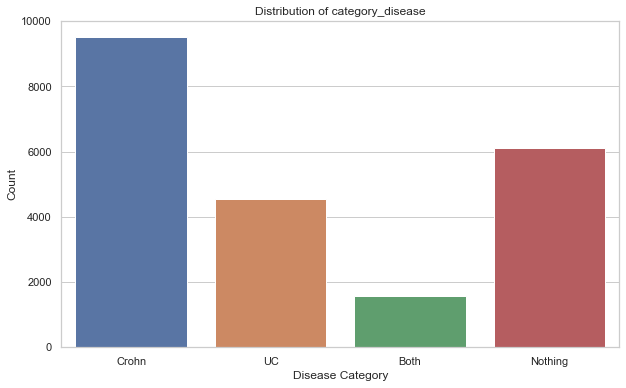

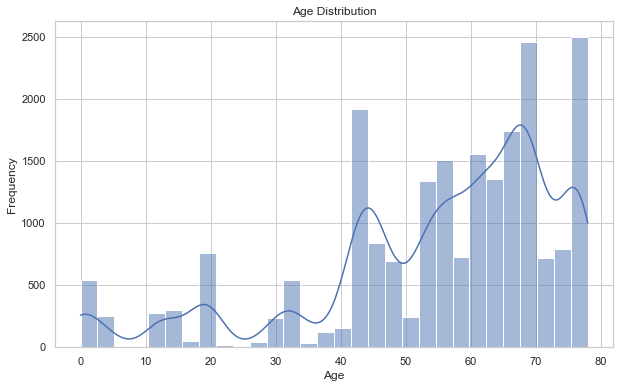

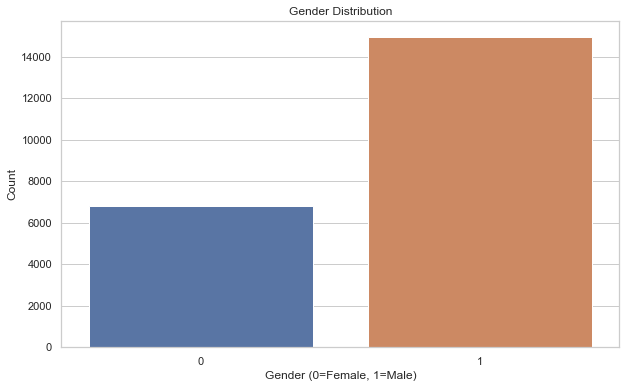

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(x='category_disease', data=data)
plt.title('Distribution of category_disease')
plt.xlabel('Disease Category')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', data=data)
plt.title('Gender Distribution')
plt.xlabel('Gender (0=Female, 1=Male)')
plt.ylabel('Count')
plt.show()

* I started with simple general observations :
    - More claims are related to Crohn disease
    - 85% of the claims are declared by persons between 40 and 75 years old. **In general medical insurances target this exact population.**
    - The male patients have much more medical claims than females

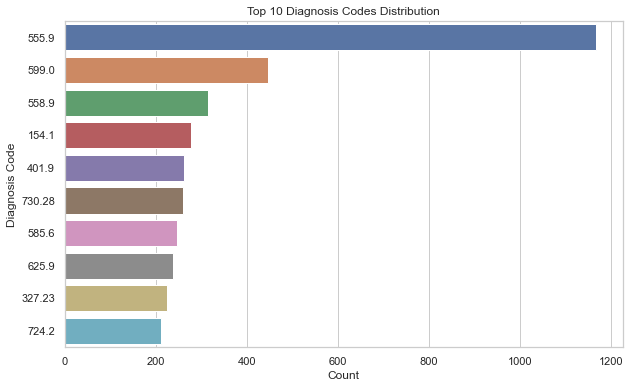

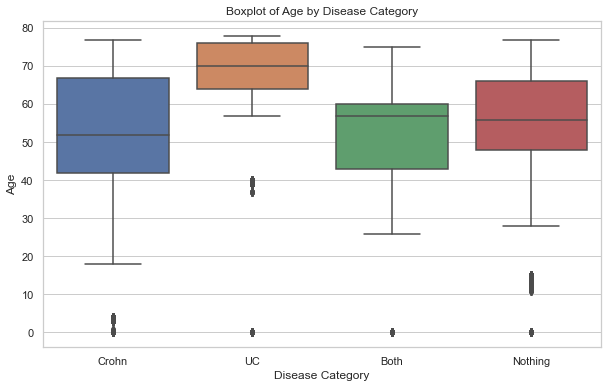

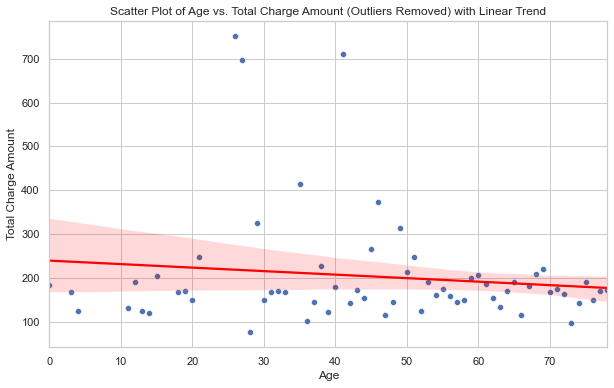

In [20]:
filtered_data = data[(data['TotalChargeAmount'] != 0) & (data['DiagnosisCode1'] != '0')]

plt.figure(figsize=(10, 6))
sns.countplot(y='DiagnosisCode1', data=filtered_data, order=filtered_data['DiagnosisCode1'].value_counts().iloc[:10].index)
plt.title('Top 10 Diagnosis Codes Distribution')
plt.xlabel('Count')
plt.ylabel('Diagnosis Code')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='category_disease', y='Age', data=filtered_data)
plt.title('Boxplot of Age by Disease Category')
plt.xlabel('Disease Category')
plt.ylabel('Age')
plt.show()



# Remove outliers in TotalChargeAmount
Q1 = filtered_data['TotalChargeAmount'].quantile(0.25)
Q3 = filtered_data['TotalChargeAmount'].quantile(0.75)
IQR = Q3 - Q1
filtered_data_no_outliers = filtered_data[~((filtered_data['TotalChargeAmount'] < (Q1 - 1.5 * IQR)) |
                                            (filtered_data['TotalChargeAmount'] > (Q3 + 1.5 * IQR)))]

average_expenses_per_age = filtered_data_no_outliers.groupby('Age')['TotalChargeAmount'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='TotalChargeAmount', data=average_expenses_per_age)
sns.regplot(x='Age', y='TotalChargeAmount', data=average_expenses_per_age, scatter=False, color='red')
plt.title('Scatter Plot of Age vs. Total Charge Amount (Outliers Removed) with Linear Trend')
plt.xlabel('Age')
plt.ylabel('Total Charge Amount')
plt.show()


* Others general observations :
    - The first plot is a count of the top 10 diagnosis (555.9 is the first one)
    - The second plot shows that patients with UC tend to be older than the others.
    - The third plot shows that average price per age tends to be lower with the age. It makes sense to me because we can also see there are more expenses for erlderly people. In general insurances are less expensive with the age but can increase their prices if there are more claims.

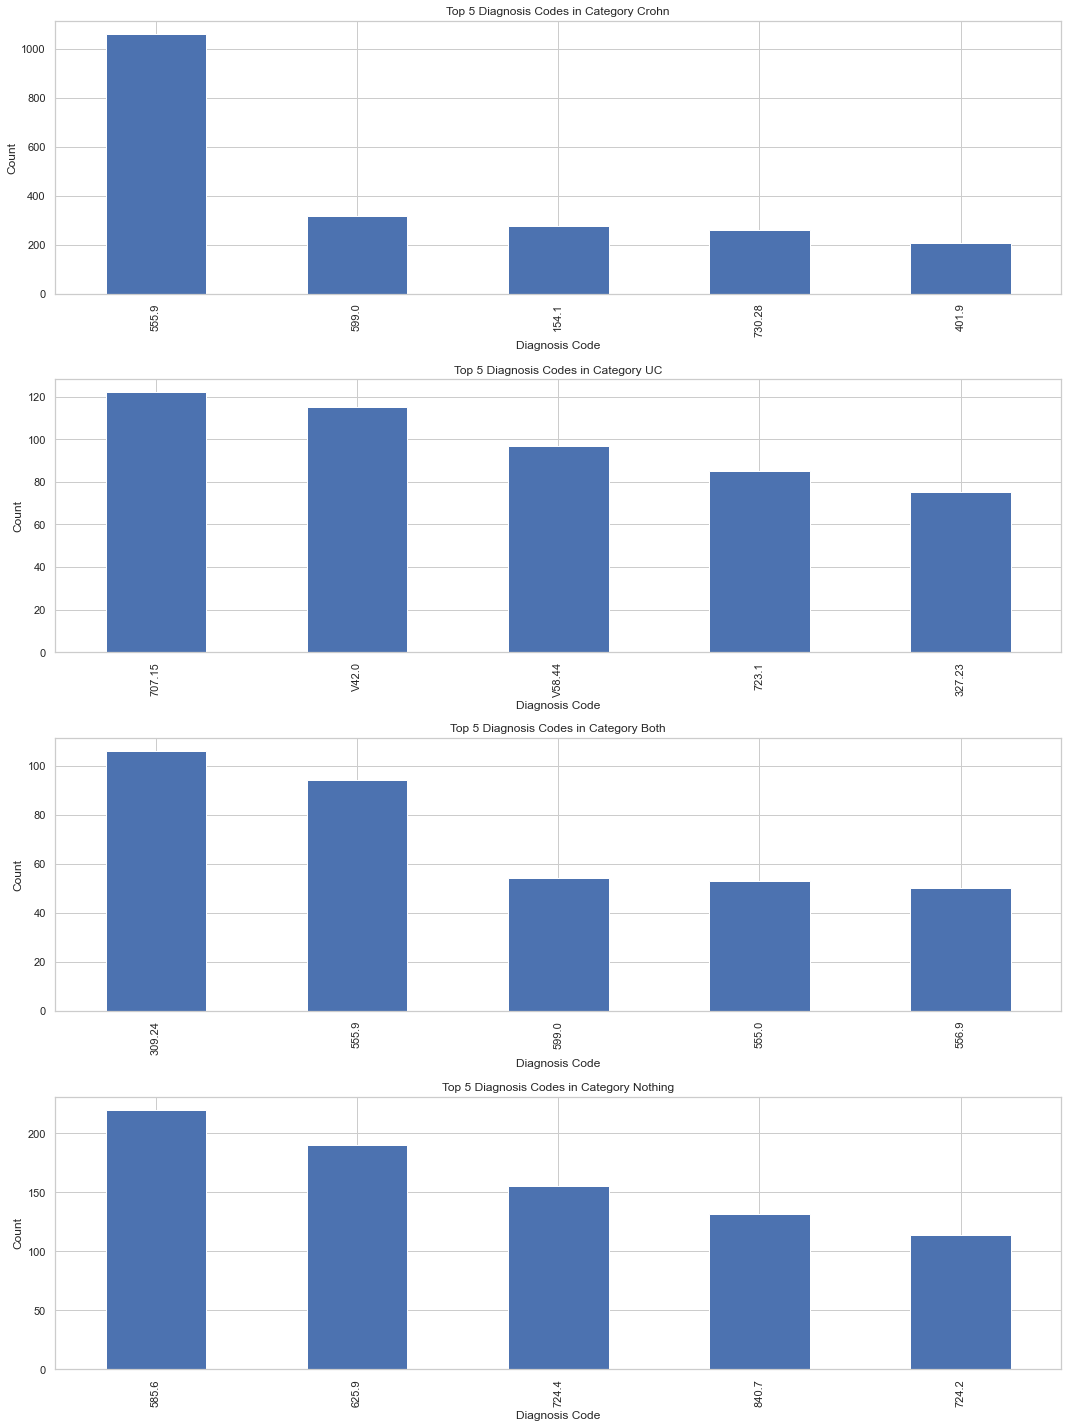

In [21]:
# Creating a function to plot the five most frequent diagnosis codes for each disease category
def plot_top_five_diagnosis_per_category(data, category_col, diagnosis_col):
    categories = data[category_col].dropna().unique()
    num_categories = len(categories)
    plt.figure(figsize=(15, 5 * num_categories))

    for i, category in enumerate(categories):
        category_data =data[data[category_col] == category]
        top_diagnoses =category_data[diagnosis_col].value_counts().head(5)
        plt.subplot(num_categories, 1, i + 1)
        top_diagnoses.plot(kind='bar')
        plt.title(f'Top 5 Diagnosis Codes in Category {category}')
        plt.xlabel('Diagnosis Code')
        plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

plot_top_five_diagnosis_per_category(filtered_data, 'category_disease', 'DiagnosisCode1')

**We can see the top 5 diagnosis per category disease.**

In [40]:
z_codes['Z_Codes'] = z_codes['Z_Codes'].str.strip()
z_codes[z_codes['Z_Codes'].isin(['Z0421', 'Z0301'])]

,Z_Codes,Details
159,Z0301,Chemistry
239,Z0421,Visit Charge


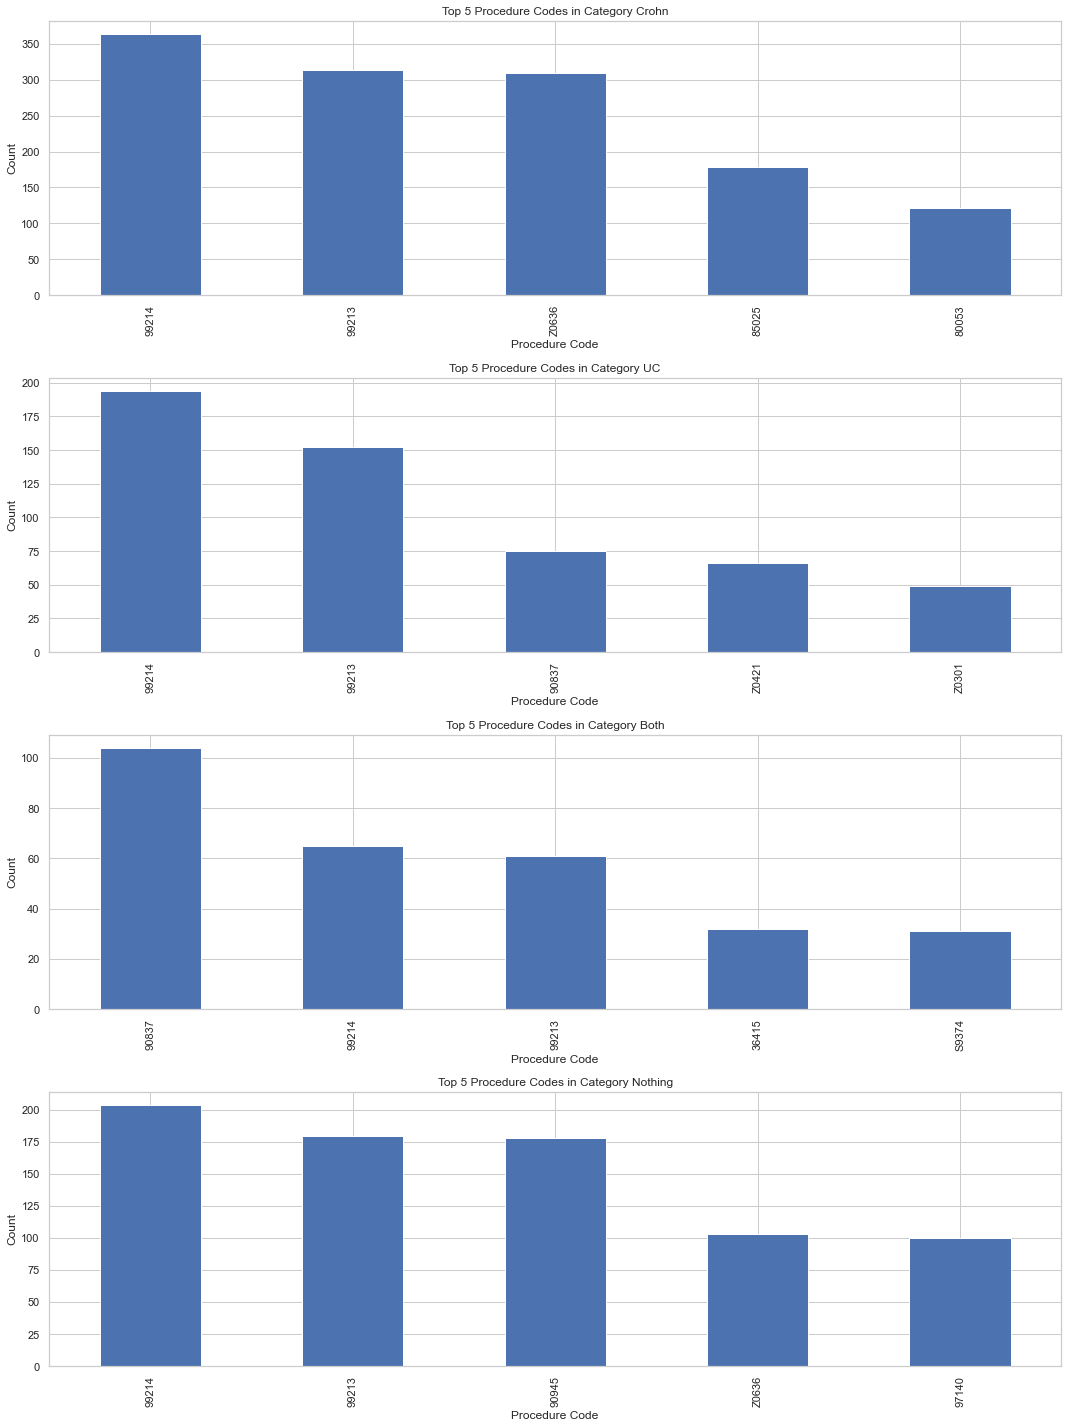

In [22]:
# Create a plot the five most frequent Procedure codes for each disease category
def plot_top_five_procedures_per_category(data, category_col, procedure_col):
    categories = data[category_col].dropna().unique()
    num_categories = len(categories)
    plt.figure(figsize=(15, 5 * num_categories))

    for i, category in enumerate(categories):
        category_data = data[data[category_col] == category]
        top_procedure = category_data[procedure_col].value_counts().head(5)
        plt.subplot(num_categories, 1, i + 1)
        top_procedure.plot(kind='bar')
        plt.title(f'Top 5 Procedure Codes in Category {category}')
        plt.xlabel('Procedure Code')
        plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

plot_top_five_procedures_per_category(filtered_data, 'category_disease', 'ProcedureCode')

**We can see the top 5 procedures per category disease. Let see what they are below :**

In [23]:
cpt4[cpt4['CPT4'].isin(['99214', '99213', 'Z0636', '85025', '80053', '36415', '90837'])]

,CPT4,Procedure
2752,36415,Routine venipuncture
6077,80053,Comprehen metabolic panel
6602,85025,Complete cbc w/auto diff wbc
8093,99213,"Office/outpatient visit, est"
8094,99214,"Office/outpatient visit, est"


**Procedures most performed to the patient with Crohn, UC, or Both are :**
* Routine venipuncture
* Comprehen metabolic panel
* Complete cbc w/auto diff wbc
* etc...

In [24]:
### 

# Function to determine if there is a shift in disease category for each ID
def determine_shift_in_disease_category(data, id_col, category_col):
    shift_info = []

    for unique_id in data[id_col].unique():
        id_data= data[data[id_col] == unique_id]
        shift =id_data[category_col].nunique() > 1
        shift_info.append({'ID': unique_id, 'Shift_in_Disease': 'Yes' if shift else 'No'})

    return pd.DataFrame(shift_info)
shift_table = determine_shift_in_disease_category(filtered_data, 'ID', 'category_disease')

# No change in desease category in the time
shift_table['Shift_in_Disease'].nunique()

1

**I would like to see if a patient was diagnosed UC, Crohn or Both after a few claims.**
 - There is no status change for one patient in the time in our dataset. I won't be able to build features based on the shift to eventually see what were previous health problems before getting sick with IBD variants.

In [25]:
# Calculating the average number of claims per ID and per disease category
average_claims = filtered_data.groupby(['ID', 'category_disease']).size().reset_index(name='Claim_Count')
average_claims_per_id_category = average_claims.groupby(['ID', 'category_disease']).mean().reset_index()

average_claims_per_id_category.head(10)

,ID,category_disease,Claim_Count
0,1001421,Crohn,542.0
1,1010930,UC,180.0
2,1017934,Both,68.0
3,1032484,Crohn,300.0
4,1035273,Crohn,94.0
5,1159334,Both,138.0
6,1188491,Nothing,124.0
7,1188541,Crohn,477.0
8,1213205,Crohn,682.0
9,1215139,Crohn,188.0


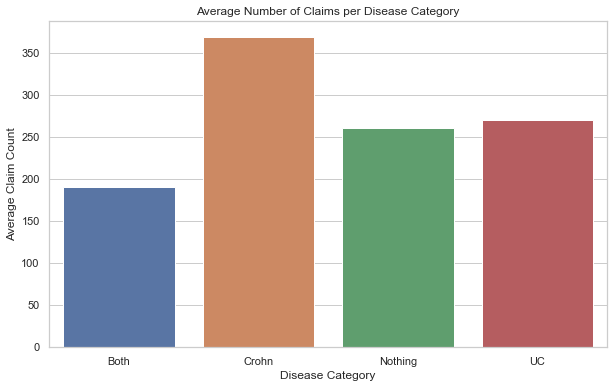

In [26]:
# average number of claims per disease category
average_claims_per_disease = average_claims_per_id_category.groupby('category_disease')['Claim_Count'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='category_disease', y='Claim_Count', data=average_claims_per_disease)
plt.title('Average Number of Claims per Disease Category')
plt.xlabel('Disease Category')
plt.ylabel('Average Claim Count')
plt.show()

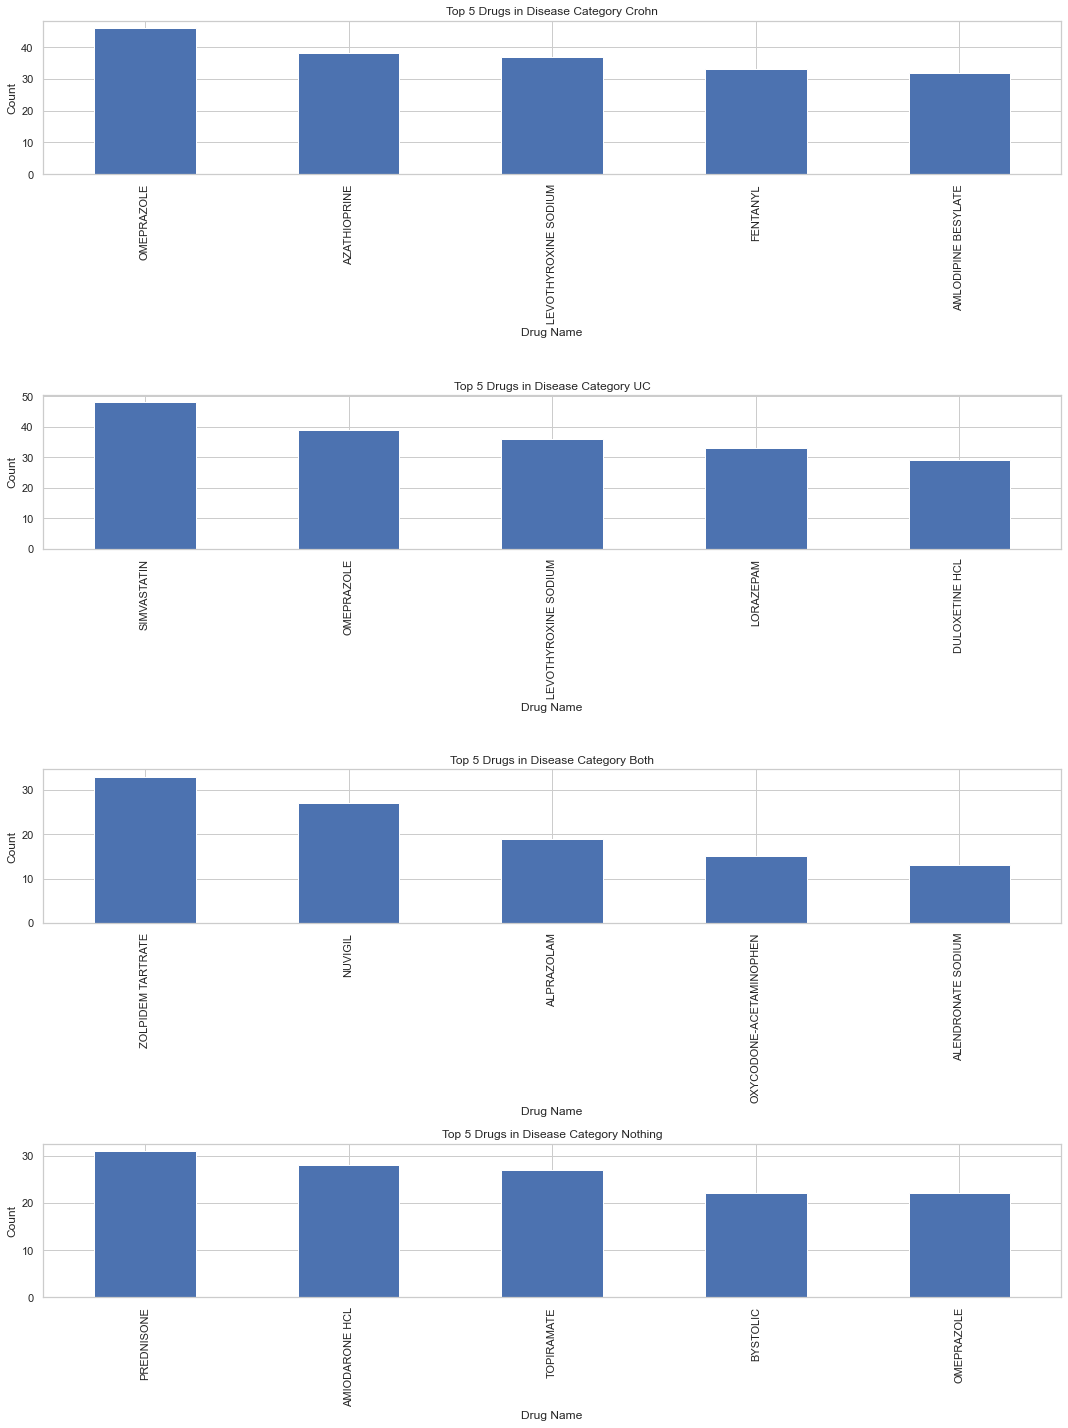

In [27]:
# I remove No_drug values because the rows are associated with other medical treatment no involving drugs medicines
drug_data = data[(data['DrugName'] != 'No_drug') & (data['DrugName'] != '0')]

def plot_top_five_drugs_per_category(data, category_col, drug_col):
    categories =data[category_col].dropna().unique()
    num_categories= len(categories)
    plt.figure(figsize=(15, 5 * num_categories))

    for i, category in enumerate(categories):

        category_data = data[data[category_col] == category]
        top_drugs = category_data[drug_col].value_counts().head(5)
        plt.subplot(num_categories, 1, i + 1)
        top_drugs.plot(kind='bar')
        plt.title(f'Top 5 Drugs in Disease Category {category}')
        plt.xlabel('Drug Name')
        plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

plot_top_five_drugs_per_category(drug_data, 'category_disease', 'DrugName')

**The top 5 per category of drugs most given to the patient.**

**There is obviously a relationship with the drug given to the patient and the disease. It is logical but it means it will help to discriminate when we will do the classification. We will check this statement with Chi2 test.**

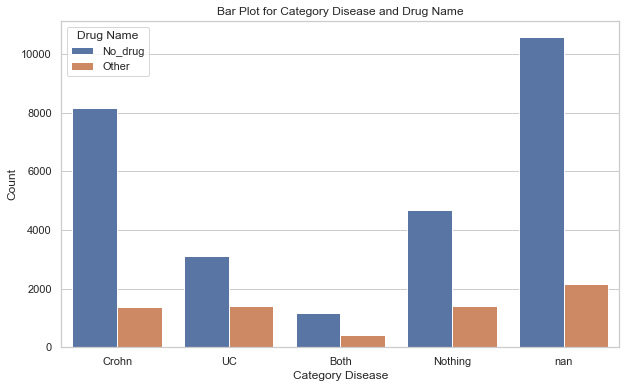

In [28]:
merged_data['DrugName'] = merged_data['DrugName'].apply(lambda x: 'Other' if x != 'No_drug' else x)

plt.figure(figsize=(10, 6))
sns.countplot(x='category_disease', hue='DrugName', data=merged_data)
plt.title('Bar Plot for Category Disease and Drug Name')
plt.xlabel('Category Disease')
plt.ylabel('Count')
plt.legend(title='Drug Name')
plt.show()

**There are more test without drugs for the Crohn and UC diseases. It could also help todiscriminate.**

In [29]:
# Use original dataset (Hidden disease category will be encoded 4 type int)
data = merged_data.copy()

In [30]:
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
encoded_data = data.copy()

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    encoded_data[col] = le.fit_transform(encoded_data[col])
    label_encoders[col] = le

encoded_data = encoded_data.drop(columns=['ClaimLineID', 'ID', 'Procedure_Date'])

In [31]:
encoded_data[['ProcedureCode', 'category_disease']]

,ProcedureCode,category_disease
0,1386,1
1,50,1
2,1158,1
3,78,1
4,1158,1
...,...,...
34483,448,4
34484,143,4
34485,1453,4
34486,1630,4


In [32]:
partial_encoded = encoded_data[encoded_data['category_disease'] != 4]
partial_encoded.tail()

,Age,Gender,DiagnosisCode1,DiagnosisCode2,DiagnosisCode3,DiagnosisCode4,DiagnosisCode5,ProcedureCode,ProcedureCodeMod,DrugClass,DrugName,DrugStrength,DrugQuantity,DrugDaysSupply,EpisodeDescription,EpisodeDriver,EpisodeCategory,TotalChargeAmount,category_disease
21746,72,1,732,650,538,0,0,1158,3,71,0,1,0,0,7,1,28,383.00,3
21747,72,1,0,0,0,0,0,1630,90,2,1,122,30,30,93,6,31,1.80,3
21748,72,1,0,0,0,0,0,1630,90,68,1,143,100,10,93,6,31,3.67,3
21749,72,1,0,0,0,0,0,1630,90,43,1,86,21,7,93,6,31,2.97,3
21750,72,1,404,347,0,0,0,1159,3,71,0,1,0,0,58,0,34,99.00,3


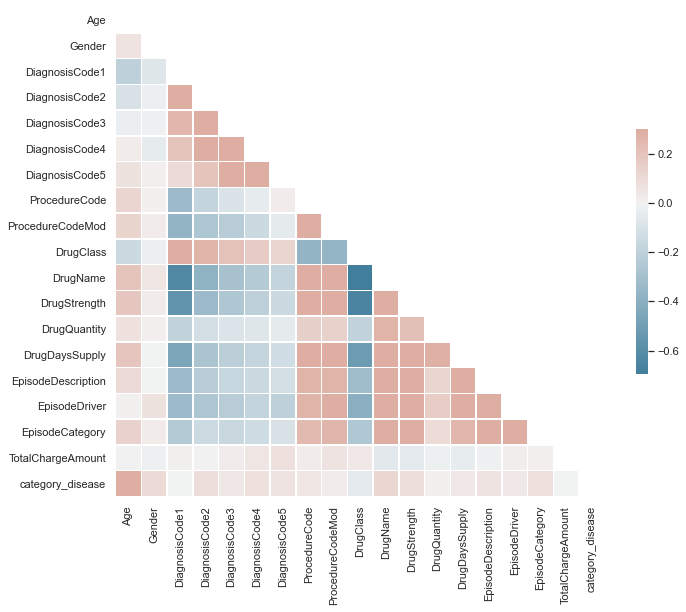

In [33]:
sns.set_theme(style="white")
corr = partial_encoded.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [34]:
data = encoded_data.dropna()

bins = [0, 18, 35, 55, 100]
labels = ['0-18', '19-35', '36-55', '56+']
data['Age_Group'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)
contingency_table = pd.crosstab(data['Age_Group'], data['category_disease'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p_value}")

# There significant association between the age groups and disease categories
# pvalue < 0.05

Chi-Square Statistic: 4143.290484969708
P-Value: 0.0


- **There significant association between the age groups and disease categories**
- **pvalue < 0.05**

In [35]:
drug_data = data[(data['DrugName'] != 'No_drug') & (data['DrugName'] != '0')]
contingency_table = pd.crosstab(drug_data['DrugName'], drug_data['category_disease'])

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_val}")

# The drug used is likely related to the disease category.

Chi-Square Statistic: 728.5017756718908
P-Value: 2.346608636697322e-156


**The drug used is likely related to the disease category.**

# Feature engineering

### The index will be ID itself
* the features are :
    * 1 - Number of claims (ClaimLineID) per ID.
    * 2 - Age
    * 3 - Gender
    * 4 - DiagnosisCode1 	DiagnosisCode2 	DiagnosisCode3 	DiagnosisCode4 	DiagnosisCode5
    * 5 - the 5 most frequent ProcedureCode in 5 columns called : (ProcedureCode_1 to ProcedureCode_5)
    * 6 - the 5 most frequent DrugClass in 5 columns called : (DrugClass_1 to DrugClass_5) that 
        exclude value 'No_drug'.
    * 7 - The column Number_Exams which will be the number of 'No_drug' found in column DrugClass per ID.
    * 8 - Number of months of a patient as customer of the insurance.
    * 9 - EpisodeDescription, EpisodeDriver and EpisodeCategory
    * 10 - TotalChargeAmount average per ID
    * 11 - TotalChargeAmount per top 5 ProcedureCode per ID excluding value '_DRUG'.
    * 12 - category_disease per ID.

In [36]:
data = merged_data.copy()

In [37]:
# Let's build the features mentionned in the list
def top_n_categories(series, n=5):
    return series.value_counts().head(n).index.tolist()

def top_5_frequent_excluding_no_drug(group, column):
    filtered_group = group[group != 'No_drug']
    return filtered_group.value_counts().head(5).index.tolist()

def most_frequent_value(series):
    return series.mode().iloc[0] if not series.mode().empty else None

def avg_charge_for_top_procedures(id_group, top_procedures):
    return id_group[id_group['ProcedureCode'].isin(top_procedures)]['TotalChargeAmount'].mean()

def calculate_months(date_series):
    return (date_series.max() - date_series.min()).days / 30

basic_agg = data.groupby('ID').agg(
    Num_Claims=('ClaimLineID', 'nunique'),
    Age=('Age', 'first'),
    Gender=('Gender', 'first'),
    DiagnosisCode1=('DiagnosisCode1', 'first'),
    DiagnosisCode2=('DiagnosisCode2', 'first'),
    DiagnosisCode3=('DiagnosisCode3', 'first'),
    DiagnosisCode4=('DiagnosisCode4', 'first'),
    DiagnosisCode5=('DiagnosisCode5', 'first'),
    Average_TotalChargeAmount=('TotalChargeAmount', 'mean'),
    Category_Disease=('category_disease', 'first')
)

top_procedure_codes = data.groupby('ID')['ProcedureCode'].apply(lambda x: top_n_categories(x, 5))
top_drug_classes = data.groupby('ID')['DrugClass'].apply(lambda x: top_n_categories(x[x != 'No_drug'], 5))
# Test
combined_data = basic_agg.join(top_procedure_codes, on='ID').join(top_drug_classes, on='ID')

top_5_drug_classes = data.groupby('ID')['DrugClass'].apply(lambda x: top_5_frequent_excluding_no_drug(x, 'DrugClass'))
top_5_drug_classes_df = top_5_drug_classes.apply(pd.Series)
top_5_drug_classes_df.columns= [f'DrugClass_{i+1}' for i in range(top_5_drug_classes_df.shape[1])]

combined_data = combined_data.join(top_5_drug_classes_df, on='ID')
combined_data['Number_Exams'] = data.groupby('ID')['DrugClass'].apply(lambda x: (x == 'No_drug').sum())

combined_data['MostFrequent_EpisodeDescription'] = data.groupby('ID')['EpisodeDescription'].apply(most_frequent_value)
combined_data['MostFrequent_EpisodeDriver'] = data.groupby('ID')['EpisodeDriver'].apply(most_frequent_value)
combined_data['MostFrequent_EpisodeCategory'] = data.groupby('ID')['EpisodeCategory'].apply(most_frequent_value)

combined_data['Avg_TotalChargeAmount'] = data.groupby('ID')['TotalChargeAmount'].mean()
combined_data['Category_Disease'] = data.groupby('ID')['category_disease'].first()

top_5_procedures = data.groupby('ID')['ProcedureCode'].apply(lambda x: top_n_categories(x[x != '_DRUG'], 5))
top_5_procedures_df = top_5_procedures.apply(pd.Series)
top_5_procedures_df.columns=[f'Procedure_{i+1}' for i in range(top_5_procedures_df.shape[1])]



avg_charge_top_5_procedures = data.groupby('ID').apply(
    lambda x: avg_charge_for_top_procedures(x, top_5_procedures[x.name])
)

combined_data = combined_data.join(top_5_procedures_df, on='ID')
combined_data['AvgCharge_Top5_Procedures'] = avg_charge_top_5_procedures

del combined_data['DrugClass']
del combined_data['ProcedureCode']


data['Procedure_Date'] = pd.to_datetime(data['Procedure_Date'])
time_spent_per_id = data.groupby('ID')['Procedure_Date'].apply(calculate_months)
combined_data.reset_index(inplace=True)
combined_data = combined_data.merge(time_spent_per_id.rename('delta_premium'), on='ID', how='left')

In [38]:
data = combined_data.copy()

# Build train and test set

In [39]:
# Encode data of new dataset
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
if 'Category_Disease' in categorical_columns:
    categorical_columns.remove('Category_Disease')
encoded_data = data.copy()

label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    encoded_data[col] = le.fit_transform(encoded_data[col])
    label_encoders[col] = le

encoded_data.index = encoded_data.ID
encoded_data = encoded_data.drop(columns=['ID'])

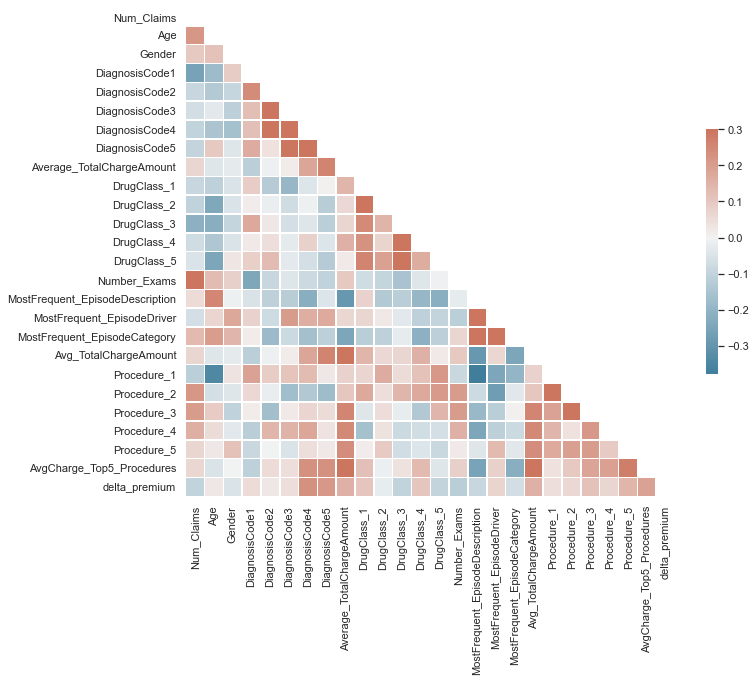

In [40]:
corr = encoded_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [41]:
train = encoded_data[encoded_data['Category_Disease'] != 'nan']
test = encoded_data[encoded_data['Category_Disease'] == 'nan'].drop(columns=['Category_Disease'])
print('Train : ', train.shape)
print('Test : ', test.shape)

Train :  (58, 27)
Test :  (42, 26)


**Now we have our 100 patients seperated in test and train set.**

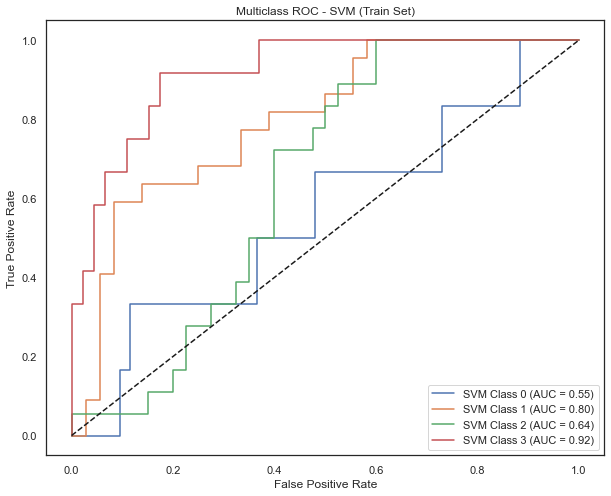

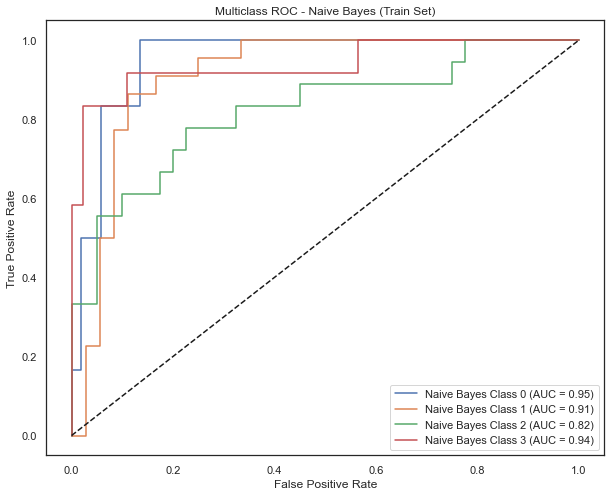

In [42]:
X_train = train.drop('Category_Disease', axis=1)
y_train = train['Category_Disease']

y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))
n_classes = y_train_binarized.shape[1]

clf_svm = SVC(probability=True)
clf_nb = GaussianNB()

clf_svm.fit(X_train, y_train)
clf_nb.fit(X_train, y_train)

def compute_multiclass_roc_auc(classifier, X, y, n_classes):
    y_prob = classifier.predict_proba(X)
    fpr = dict() 
    tpr = dict() 
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

fpr_svm,  tpr_svm, roc_auc_svm = compute_multiclass_roc_auc(clf_svm, X_train, y_train_binarized, n_classes)
fpr_nb, tpr_nb, roc_auc_nb= compute_multiclass_roc_auc(clf_nb, X_train, y_train_binarized, n_classes)

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_svm[i], tpr_svm[i], label=f'SVM Class {i} (AUC = {roc_auc_svm[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multiclass ROC - SVM (Train Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr_nb[i], tpr_nb[i], label=f'Naive Bayes Class {i} (AUC = {roc_auc_nb[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Multiclass ROC - Naive Bayes (Train Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

**The AUC for all categories predicted by NaiveBayes are better so let's use this one to do the predictions on test set.**

In [43]:
best_model = clf_svm if sum(roc_auc_svm.values()) > sum(roc_auc_nb.values()) else clf_nb
predictions = best_model.predict(test)
test['Predictions'] = predictions

In [44]:
test[['Predictions']].head()

,Predictions
ID,
2003936,Nothing
2010093,UC
2050028,Crohn
2054592,Crohn
2074386,Both


# Conclusion :
**We see that there is a strong relationship between drugs, procedures and IBD variants. We could show the evidences that they exist and help to identify the IBD variant diagnosis to a patient we do not know.**

Sources :
- https://github.com/robinmasliah
- https://stackoverflow.com/
- https://pubmed.ncbi.nlm.nih.gov/32084423/
- Internal documentation of https://bnpparibascardif.cl/home